<a href="https://colab.research.google.com/github/haotianxu2021/machineLearningProjectsCollection/blob/main/play_prediction/play_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
import numpy as np

In [ ]:
def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

In [ ]:
def readGz(path):
    for l in gzip.open(path, 'rt', encoding='utf-8'):
        yield eval(l)

In [ ]:
def readJSON(path):
    f = gzip.open(path, 'rt', encoding='utf-8')
    f.readline()
    for l in f:
        d = eval(l)
        u = d['userID']
        g = d['gameID']
        yield u,g,d

In [ ]:
# Some data structures that will be useful

In [ ]:
allHours = []
for l in readJSON("train.json.gz"):
    allHours.append(l)

In [ ]:
hoursTrain = allHours[:165000]
hoursValid = allHours[165000:]
hoursPerUser = defaultdict(list)
hoursPerItem = defaultdict(list)
reviewPerUser = defaultdict(set)
reviewPerItem = defaultdict(set)
userHourMean = 0
itemHourMean = 0
userTextMean = 0
itemTextMean = 0
for u,g,d in hoursTrain:
    r = d['hours_transformed']
    hoursPerUser[u].append((g,r))
    hoursPerItem[g].append((u,r))
    userHourMean += r
    itemHourMean += r
    reviewPerUser[u].add(len(d['text']))
    userTextMean += len(d['text'])
    reviewPerItem[g].add(len(d['text']))
    itemTextMean += len(d['text'])
userHourMean /= len(hoursPerUser)
itemHourMean /= len(hoursPerItem)
userTextMean /= len(reviewPerUser)
itemTextMean /= len(reviewPerItem)

In [ ]:
##################################################
# Play prediction                                #
##################################################

In [ ]:
# From baseline code
gameCount = defaultdict(int)
totalPlayed = 0

for u,g,_ in hoursTrain:
    gameCount[g] += 1
    totalPlayed += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalPlayed/2: break

In [ ]:
# Generate a negative set

userSet = set()
gameSet = set()
playedSet = set()

for u,g,d in allHours:
    userSet.add(u)
    gameSet.add(g)
    playedSet.add((u,g))

lUserSet = list(userSet)
lGameSet = list(gameSet)

notPlayed = set()
for u,g,d in hoursValid:
    #u = random.choice(lUserSet)
    g = random.choice(lGameSet)
    while (u,g) in playedSet or (u,g) in notPlayed:
        g = random.choice(lGameSet)
    notPlayed.add((u,g))

playedValid = set()
for u,g,r in hoursValid:
    playedValid.add((u,g))

notTrain = set()
for u,g,d in hoursTrain:
    #u = random.choice(lUserSet)
    g = random.choice(lGameSet)
    while (u,g) in playedSet or (u,g) in notTrain:
        g = random.choice(lGameSet)
    notTrain.add((u,g))

playedTrain = set()
for u,g,r in hoursTrain:
    playedTrain.add((u,g))

In [ ]:
itemsPerUser = defaultdict(set)
usersPerItem = defaultdict(set)
#allGame = set()
hourDict = {}
for d in hoursTrain:
    u = d[0]
    g = d[1]
    usersPerItem[g].add(u)
    itemsPerUser[u].add(g)
    hourDict[(u,g)] = d[2]['hours_transformed']
    #allGame.add(g)
userAverages = defaultdict(lambda: globalAverage)
itemAverages = defaultdict(lambda: globalAverage)

for u in itemsPerUser:
    rs = [hourDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)

for i in usersPerItem:
    rs = [hourDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

In [ ]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [ ]:
def CosineSet(s1, s2):
    # Not a proper implementation, operates on sets so correct for interactions only
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

In [ ]:
def Pearson(i1, i2):
    # Between two items
    iBar1 = itemAverages[i1]
    iBar2 = itemAverages[i2]
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += (hourDict[(u,i1)] - iBar1)*(hourDict[(u,i2)] - iBar2)
    for u in inter: #usersPerItem[i1]:
        denom1 += (hourDict[(u,i1)] - iBar1)**2
    #for u in usersPerItem[i2]:
        denom2 += (hourDict[(u,i2)] - iBar2)**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [ ]:
def dice_coefficient(s1, s2):
    numer = 2 * len(s1.intersection(s2))
    denom = len(s1) + len(s2)
    return numer / denom if denom > 0 else 0


In [ ]:
def overlap_coefficient(s1, s2):
    numer = len(s1.intersection(s2))
    denom = min(len(s1), len(s2))
    return numer / denom if denom > 0 else 0


In [ ]:
userIDs,itemIDs = {},{}

for d in allHours:
    u,g = d[0],d[1]
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not g in itemIDs: itemIDs[g] = len(itemIDs)

nUsers,nItems = len(userIDs),len(itemIDs)

In [ ]:
Xui = scipy.sparse.lil_matrix((nUsers, nItems))
for d in allHours:
    Xui[userIDs[d[0]],itemIDs[d[1]]] = 1

Xui_csr = scipy.sparse.csr_matrix(Xui)

In [ ]:
from implicit import bpr
model = bpr.BayesianPersonalizedRanking(factors = 5)
model.fit(Xui_csr)

In [ ]:
itemFactors = model.item_factors
userFactors = model.user_factors

In [ ]:
def feature1(d):
  f = [1]
  u = d[0]
  g = d[1]
  jSim = 0
  jSim2 = 0
  jSim3 = 0
#   if g not in hoursPerItem:
#       jSim = 0.0022798170033482357
#       cosSim = 0.005154011148885324
#       pSim = 0.9299402156364783
#       dSim = 0.004509630826211442
#       oSim = 0.008850095157601514
#       jSim2 = 0.0459941652533766
#       cosSim2 = 0.09410976452395077
#       dSim2 = 0.08746234921059354
#       oSim2 = 0.188463016358414
#   else:
  users = set(hoursPerItem[g])
  users2 = set(usersPerItem[g])
  items = set(itemsPerUser[u])
#   time = userHourMean[u] if u in userHourMean else itemHourMean[g]
#   text = userTextMean[u] if u in userTextMean else itemTextMean[g]
  for index, (g2,r) in enumerate(hoursPerUser[u]):
    if g2 == g:
      continue
    jSim = max(Jaccard(users,set(hoursPerItem[g2])), jSim)
#     cosSim = max(CosineSet(users,set(hoursPerItem[g2])), cosSim)
#     pSim = max(Pearson(g,g2), pSim)
#     dSim = max(dice_coefficient(users,set(hoursPerItem[g2])), dSim)
#     oSim = max(overlap_coefficient(users,set(hoursPerItem[g2])), oSim)
    jSim2 = max(Jaccard(users2,set(usersPerItem[g2])), jSim2)
#     cosSim2 = max(CosineSet(users2,set(usersPerItem[g2])), cosSim2)
#     # pSim2 = max(Pearson(g,g2), pSim2)
#     dSim2 = max(dice_coefficient(users2,set(usersPerItem[g2])), dSim2)
#     oSim2 = max(overlap_coefficient(users2,set(usersPerItem[g2])), oSim2)
  for u2,r in hoursPerItem[g]:
        if u2==u:
            continue
        jSim3 = max(Jaccard(items,set(itemsPerUser[u2])), jSim3)
#   score = 0
#   if (u not in userIDs.keys()) or (i not in itemIDs.keys()):
#     score = 0
#   else:
#     itemFactor = itemFactors[itemIDs[i]]
#     userFactor = userFactors[userIDs[u]]
#     score = np.dot(userFactor, itemFactor)
  user_index = userIDs.get(u, None)
  bpr_rec = 0
  if user_index is not None:
    user_vector = Xui_csr[user_index]
    recommended = model.recommend(user_index, Xui_csr[user_index], N=500, filter_already_liked_items=False)
    if itemIDs[g] in set(recommended[0]):
        bpr_rec = 1
  item_len = len(hoursPerItem.get(g, []))
#   item_av = itemAverages.get(g,0)
#   item_hr = sum([r for _,r in hoursPerItem.get(g, [])])
#   user_len = len(hoursPerUser.get(u, []))
  item_log = math.log2(item_len) if item_len > 0 else 0
#   hr_log = math.log2(item_hr) if item_hr > 0 else 0
#   user_log = math.log2(user_len) if user_len > 0 else 0
  f = [jSim, jSim2, jSim3, item_len, item_log, bpr_rec]
  return f


In [ ]:
X_1 = [feature1(d) for label, sample in [(1, playedTrain), (0, notTrain)] for d in sample]
y_1 = [label for label, sample in [(1, playedTrain), (0, notTrain)] for d in sample]

In [ ]:
np.mean([x[6] for x in X_1[0:len(X_1)//2]])

-0.41162935

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifierCV
# from sklearn.cluster import KMeans
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV

reg = RidgeClassifierCV(cv=3)
reg.fit(X_1, y_1)

RidgeClassifierCV(cv=3)

In [ ]:
y1valid = [label for label, sample in [(1, playedValid), (0, notPlayed)] for d in sample]
X1valid = [feature1(d) for label, sample in [(1, playedValid), (0, notPlayed)] for d in sample]

In [ ]:
X1valid[-10:-1]

[[1, 0, 0, 1.0, 0, 0, -1.1958413, 38],
 [1,
  0.01020408163265306,
  0.020203050891044214,
  1.0,
  0.020202020202020204,
  0.02040816326530612,
  -1.3961333,
  50],
 [1,
  0.004784688995215311,
  0.010216322170996611,
  1.0,
  0.009523809523809525,
  0.014925373134328358,
  0.88969195,
  67],
 [1, 0, 0, 1.0, 0, 0, -1.0967652, 19],
 [1,
  0.0022123893805309734,
  0.004416313253071939,
  0.8403361030046421,
  0.004415011037527594,
  0.004524886877828055,
  -1.4731504,
  232],
 [1, 0, 0, 1.0, 0, 0, -0.67704123, 17],
 [1,
  0.006369426751592357,
  0.01480872194397731,
  1.0,
  0.012658227848101266,
  0.02631578947368421,
  0.17560877,
  38],
 [1, 0, 0, 1.0, 0, 0, 1.4691615, 37],
 [1, 0, 0, 1.0, 0, 0, -1.0599993, 20]]

In [ ]:
y_pred = reg.predict(X1valid)
y_tr = reg.predict(X_1)
print(sum([y_pred[i] == y1valid[i] for i in range(len(y1valid))]) / len(y1valid))
print(sum([y_tr[i] == y_1[i] for i in range(len(y_1))]) / len(y_1))

0.6758675867586759
0.6964606060606061


In [ ]:
for a in range(8,14):
  reg = RandomForestClassifier(max_depth=a)
  reg.fit(X_1, y_1)
  y_pred = reg.predict(X1valid)
  # y_tr = reg.predict(X_1)
  print(a, sum([y_pred[i] == y1valid[i] for i in range(len(y1valid))]) / len(y1valid))
  # print(sum([y_tr[i] == y_1[i] for i in range(len(y_1))]) / len(y_1))

8 0.7024702470247025
9 0.7017701770177017
10 0.7025202520252025
11 0.7023202320232024
12 0.7022202220222022
13 0.7021202120212021


In [ ]:
hoursTrain = allHours[:165000]
hoursValid = allHours[165000:]
hoursPerUser = defaultdict(list)
hoursPerItem = defaultdict(list)
reviewPerUser = defaultdict(list)
reviewPerItem = defaultdict(list)
userHourMean = defaultdict(float)
itemHourMean = defaultdict(float)
userTextMean = defaultdict(float)
itemTextMean = defaultdict(float)
for u,g,d in allHours:
    r = d['hours_transformed']
    hoursPerUser[u].append((g,r))
    hoursPerItem[g].append((u,r))
#     userHourMean[u].append(r)
#     itemHourMean[i].append(r)
    reviewPerUser[u].append(len(d['text']))
#     userTextMean[u].append(len(d['text']))
    reviewPerItem[g].append(len(d['text']))
#     itemTextMean[i].append(len(d['text']))
for u,g,d in allHours:
    userHourMean[u] = sum([r for _,r in hoursPerUser[u]])/len(hoursPerUser)
    itemHourMean[g] = sum([r for _,r in hoursPerItem[g]])/len(hoursPerItem)
    userTextMean[u] = sum([r for r in reviewPerUser[u]])/len(reviewPerUser)
    itemTextMean[g] = sum([r for r in reviewPerItem[g]])/len(reviewPerItem)

In [ ]:
itemsPerUser = defaultdict(set)
usersPerItem = defaultdict(set)
#allGame = set()
hourDict = {}
for d in allHours:
    u = d[0]
    g = d[1]
    usersPerItem[g].add(u)
    itemsPerUser[u].add(g)
    hourDict[(u,g)] = d[2]['hours_transformed']
    #allGame.add(g)
userAverages = defaultdict(lambda: globalAverage)
itemAverages = defaultdict(lambda: globalAverage)

for u in itemsPerUser:
    rs = [hourDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)

for i in usersPerItem:
    rs = [hourDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)

In [ ]:
X_comb = [feature1(d) for label, sample in [(1, playedTrain), (0, notTrain), (1, playedValid), (0, notPlayed)] for d in sample]
print(len(X_comb))
y_comb = [label for label, sample in [(1, playedTrain), (0, notTrain), (1, playedValid), (0, notPlayed)] for d in sample]

349998


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
params = {}
mod = LogisticRegression(C=0.001)
gr = GridSearchCV(mod, params, cv=3)
gr.fit(X_comb, y_comb)
print(gr.best_score_)
print(gr.best_params_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 165000, number of negative: 165000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 330000, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(max_depth=7)

In [ ]:
reg = LogisticRegression(C=0.0005, random_state=1)
reg.fit(X_comb, y_comb)
reg2 = LogisticRegression(C=0.005, random_state=2)
reg2.fit(X_comb, y_comb)
reg3 = LogisticRegression(C=0.001, random_state=3)
reg3.fit(X_comb, y_comb)
reg4 = LinearSVC(C=0.01, random_state=4)
reg4.fit(X_comb, y_comb)
reg5 = LinearSVC(C=0.1, random_state=5)
reg5.fit(X_comb, y_comb)

In [ ]:
def popu_meta(u,g, thres, thres1, thres2):
#     jSim = 0
#     cosSim = 0
#     users2 = set(usersPerItem[g])
#     for index, (g2,r) in enumerate(hoursPerUser[u]):
#         if g2 == g:
#           continue
#         jSim = max(Jaccard(users2,set(usersPerItem[g2])), jSim)
#         cosSim = max(CosineSet(users2,set(usersPerItem[g2])), cosSim)
    pred = 0
    if len(hoursPerItem[g]) > thres or reg.predict([feature1((u,g))])[0] or reg2.predict([feature1((u,g))])[0] or reg3.predict([feature1((u,g))])[0] or reg4.predict([feature1((u,g))])[0]:
        return 1
    else:
        return 0

In [ ]:
predictions = open("predictions_Played.csv", 'w')
for l in open("pairs_Played.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    # maxSim = 0
    # users = set(hoursPerItem[g])
    # for g2,_ in hoursPerUser[u]:
    #     sim = Jaccard(users,set(hoursPerItem[g2]))
    #     if sim > maxSim:
    #         maxSim = sim
    # pred = 0
    # if maxSim > 0.028 or len(hoursPerItem[g]) > 73:
    #     pred = 1
    # pred = popu_meta(u, g, 90, 0.25, 0.15)
    pred = reg3.predict([feature1((u,g))])[0]
    _ = predictions.write(u + ',' + g + ',' + str(pred) + '\n')

predictions.close()

In [ ]:
##################################################
# Hours played prediction                        #
##################################################

In [ ]:
trainHours = [r[2]['hours_transformed'] for r in hoursTrain]
globalAverage = sum(trainHours) * 1.0 / len(trainHours)

In [ ]:
len(allHours)

174999

In [ ]:
validMSE = 0
for u,g,d in hoursValid:
    r = d['hours_transformed']
    se = (r - globalAverage)**2
    validMSE += se

validMSE /= len(hoursValid)

print("Validation MSE (average only) = " + str(validMSE))

Validation MSE (average only) = 5.316020858088501


In [ ]:
### Question 6
## latent methods
import numpy as np

In [ ]:
betaU = {}
betaI = {}
for u in hoursPerUser:
    betaU[u] = 0

for g in hoursPerItem:
    betaI[g] = 0
k = 1
gammaU = defaultdict(lambda: np.zeros(k))
gammaI = defaultdict(lambda: np.zeros(k))
for u in hoursPerUser:
    gammaU[u] = np.zeros(k)

for g in hoursPerItem:
    gammaI[g] = np.zeros(k)

In [ ]:
alpha = globalAverage # Could initialize anywhere, this is a guess

In [ ]:
def iterateHW3(lamb, tole = 0.00001):
    # ...
    global alpha
    previous_mse = float('inf')
    pre_valid_mse = float('inf')
    stop = False
    count = 0
    while not stop:
        # preds = []
        count += 1
        alpha_sum = 0
        betaU_sum = defaultdict(float)
        betaI_sum = defaultdict(float)

        # Accumulate updates
        for u, i, data in hoursTrain:
            hour = data['hours_transformed']
            prediction = alpha + betaU[u] + betaI[i]
            error = hour - prediction
            alpha_sum += error
            betaU_sum[u] += error
            betaI_sum[i] += error

        # Apply updates
        alpha += (alpha_sum / len(hoursTrain))
        for u in betaU:
            betaU[u] += (betaU_sum[u] - betaU[u]) / (lamb + len(hoursPerUser[u]))
        for i in betaI:
            betaI[i] += (betaI_sum[i] - betaI[i]) / (lamb + len(hoursPerItem[i]))
        preds = [alpha + betaU[d[0]] + betaI[d[1]] for d in hoursTrain]
        mse = MSE(trainHours, preds)
        validMSE = 0
        for a, b, c in hoursValid:
            r = c['hours_transformed']
            bu = betaU.get(a, 0)  # Default to 0 if user not in betaU
            bi = betaI.get(b, 0)  # Default to 0 if item not in betaI
            prediction = alpha + bu + bi
            validMSE += (r - prediction) ** 2

        validMSE /= len(hoursValid)
        if abs(pre_valid_mse - validMSE) < tole or validMSE > pre_valid_mse:
            stop = True
            break
        previous_mse = mse
        pre_valid_mse = validMSE
        print(validMSE)
def iterate(lamb, lamb2):
    newAlpha = sum(d['hours_transformed'] - (betaU[u] + betaI[g] + np.dot(gammaU[u], gammaI[g])) for u, g, d in hoursTrain)
    alpha = newAlpha / len(hoursTrain)
    for u in hoursPerUser:
        betaU[u] = sum(r - (alpha + betaI[g] + np.dot(gammaU[u], gammaI[g])) for g, r in hoursPerUser[u]) / (lamb + len(hoursPerUser[u]))
    for g in hoursPerItem:
        betaI[g] = sum(r - (alpha + betaU[u] + np.dot(gammaU[u], gammaI[g])) for u, r in hoursPerItem[g]) / (lamb + len(hoursPerItem[g]))
    for u in gammaU:
        for i in range(k):
            gammaU[u][i] = sum((r - (alpha + betaU[u] + betaI[g])) * gammaI[g][i] for g, r in hoursPerUser[u]) / (lamb2 + sum(gammaI[g][i]**2 for g in hoursPerUser[u]))
    for g in gammaI:
        for i in range(k):
            gammaI[g][i] = sum((r - (alpha + betaU[u] + betaI[g])) * gammaU[u][i] for u, r in hoursPerItem[g]) / (lamb2 + sum(gammaU[u][i]**2 for u in hoursPerItem[g]))
    mse = sum((d['hours_transformed'] - (alpha + betaU[u] + betaI[g] + np.dot(gammaU[u], gammaI[g])))**2 for u, g, d in hoursTrain) / len(hoursTrain)
    regularizer = sum(betaU[u]**2 for u in betaU) + sum(betaI[g]**2 for g in betaI) + sum(np.dot(gammaU[u], gammaU[u]) for u in gammaU) + sum(np.dot(gammaI[g], gammaI[g]) for g in gammaI)
    return mse, mse + lamb * regularizer + lamb2 * regularizer

In [ ]:
mse,objective = iterate(0.1, 0.1)
newMSE,newObjective = iterate(0.1, 0.1)
iterations = 2

In [ ]:
while abs(newObjective - objective) > 0.1:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(0.1, 0.1)
    iterations += 1
    print("Objective after "
        + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after "
        + str(iterations) + " iterations = " + str(newMSE))

Objective after 3 iterations = 839.0916144069411
MSE after 3 iterations = 2.7543416959133262
Objective after 4 iterations = 845.4124101322327
MSE after 4 iterations = 2.753584278742793
Objective after 5 iterations = 847.3272431172555
MSE after 5 iterations = 2.7535231380236116
Objective after 6 iterations = 847.8555350800967
MSE after 6 iterations = 2.7535179689000615
Objective after 7 iterations = 847.9830997477553
MSE after 7 iterations = 2.7535174860787506
Objective after 8 iterations = 847.9968205617836
MSE after 8 iterations = 2.753517429027501


In [ ]:
iterateHW3(100, 0.001)
iterateHW3(1000, 0.00001)
iterateHW3(5000, 0.000001)

3.5289976505859846
3.217151598921083
3.101843611927979
3.057242266282934
3.026761215852807
3.0149271966932556
3.0036838148955316
3.000634699318946
2.9962861549684607
2.9952720210175356
2.99520674059655
2.9950579861967803
2.9949613452322215
2.9948822134480966
2.994820932700761
2.994773408879028
2.9947375829374474
2.9947118068475507
2.9946948726304656
2.994716312928075
2.9947058751835947
2.9946984775135026
2.9946920992088755
2.9946867129987558
2.994682222292867
2.9946785460988194
2.9946756136154455
2.9946733629190656
2.9946717397101916
2.994670696254018


In [ ]:
validMSE = 0
for u, g, d in hoursValid:
    r = d['hours_transformed']
    bu = betaU.get(u, 0)  # Default to 0 if user not in betaU
    bi = betaI.get(g, 0)  # Default to 0 if item not in betaI
    gu = gammaU.get(u, np.zeros(k))  # Default to zero vector if user not in gammaU
    gi = gammaI.get(g, np.zeros(k))  # Default to zero vector if item not in gammaI

    # Dot product of user and item latent factors
    # dot_product = np.dot(gu, gi)

    # Prediction includes user bias, item bias, and dot product of latent factors
    prediction = alpha + bu + bi

    # Update MSE
    validMSE += (r - prediction) ** 2

validMSE /= len(hoursValid)
print("Validation MSE = " + str(validMSE))

Validation MSE = 2.994670190478112


In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163482 sha256=00c191ae0651f5f4d1b791e4ecb6908606bce952d85261e17276436eb03a559f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
# latent using surprise
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
import pandas as pd

In [ ]:
newTrain = [[d[0], d[1],d[2]['hours_transformed']] for d in allHours]
maxHour = max([d[2] for d in newTrain])
minHour = min([d[2] for d in newTrain])
maxHour

14.013750114071462

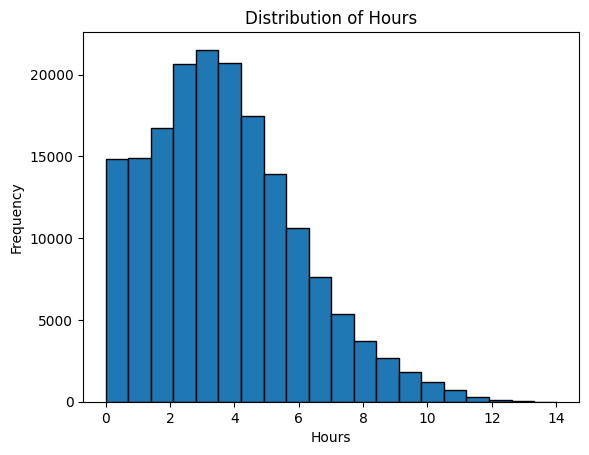

In [ ]:
df = pd.DataFrame(newTrain, columns=['userID', 'itemID', 'hour'])
import matplotlib.pyplot as plt

plt.hist(df['hour'], bins=20, edgecolor='black')
plt.title('Distribution of Hours')
plt.xlabel('Hours')
plt.ylabel('Frequency')
plt.show()

In [ ]:
filtered_df = df[(df['hour'] > 0) & (df['hour'] <= 12)]

In [ ]:
data = Dataset.load_from_df(df, Reader(rating_scale=(0, 10)))

# Use the SVD algorithm
algo = SVD()

# Perform cross-validation and print results
# cross_validate(algo, data, measures=['MSE', 'MAE'], cv=5, verbose=True)
trainset = data.build_full_trainset()
# algo.fit(trainset)


In [ ]:
newValid = [[d[0], d[1],d[2]['hours_transformed']] for d in hoursValid]
dataValid = pd.DataFrame(newValid, columns=['userID', 'itemID', 'hour'])
# y_pred = []
# for _, row in dataValid.iterrows():
#     prediction = algo.predict(row['userID'], row['itemID'])
#     y_pred.append(prediction.est)

In [ ]:
y_valid = [d[2]['hours_transformed'] for d in hoursValid]
def MSE(y, ypred):
    # ...
    differences = [(x-y)**2 for x,y in zip(ypred,y)]
    return sum(differences) / len(differences)
# print(MSE(y_valid, y_pred))

In [ ]:
from surprise.model_selection import GridSearchCV
from surprise import NMF, KNNBasic, SVDpp, SlopeOne, KNNWithMeans, KNNBaseline, CoClustering, KNNWithZScore, BaselineOnly
param_grid = {
    'n_factors': [0],
    'n_epochs': [1500],
    'init_std_dev': [0],
    'init_mean': [0],
    'reg_bu': [0.1],
    'reg_bi': [0.001],
    'reg_pu': [0],
    'reg_qi': [0],
    'lr_bu': [0.0001],
    'lr_bi': [0.0001],
    'lr_pu': [0.0001],
    'lr_qi': [0.0001],
    'verbose': [False]
}
p2 = {
    'k':[1000],
    'min_k':[900,800]
}
p3 = {
    'bsl_options': {
        "method": ["als"],
        "n_epochs": [2,3],
        "reg_u": [10], "reg_i": [1]
    }
}
gs = GridSearchCV(BaselineOnly, p3, measures=['mse'], cv=3)
gs.fit(data)
print(gs.best_score['mse'])
print(gs.best_params['mse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
3.05212826055955
{'bsl_options': {'method': 'als', 'n_epochs': 2, 'reg_u': 10, 'reg_i': 1}}


In [ ]:
print(gs.best_score['mse'])
print(gs.best_params['mse'])

3.092460705976865
{'n_factors': 1, 'n_epochs': 10, 'init_std_dev': 0, 'init_mean': 0, 'reg_bu': 0.1, 'reg_bi': 0, 'reg_pu': 0, 'reg_qi': 0, 'lr_bu': 0.004, 'lr_bi': 0.008, 'lr_pu': 0.005, 'lr_qi': 0.005, 'verbose': False}


In [ ]:
from surprise import NMF, KNNBasic, SVDpp, SlopeOne, KNNWithMeans, KNNBaseline, CoClustering, KNNWithZScore, BaselineOnly
algo = SVD(n_factors=1, n_epochs=20,lr_bi = 0.008,lr_bu=0.004,lr_pu=0.005,lr_qi=0.005,
                 reg_bu=0.1, reg_bi=0,reg_pu=0,reg_qi=0)
# algo1 = NMF(reg_pu=0.2, reg_qi=0.2, reg_bu=0.2, reg_bi=0.2)
# algo2 = KNNBasic(min_k=5)
# algo3 = SVDpp(reg_all=0.3)
# algo4 = SlopeOne()
# algo5 = KNNWithMeans(min_k=5)
# algo6 = KNNBaseline(min_k=1000, k=1000)
# # algo7 = CoClustering(n_cltr_u = 7, n_cltr_i = 7)
# algo8 = KNNWithZScore(min_k=5)
bsl_op = {
        "method": "als",
        "n_epochs": 2,
        "reg_u": 10, "reg_i": 1
    }
algo9 = BaselineOnly(bsl_options=bsl_op)
algo.fit(trainset)
# algo1.fit(trainset)
# algo2.fit(trainset)
# algo3.fit(trainset)
# algo4.fit(trainset)
# algo5.fit(trainset)
# algo6.fit(trainset)
# # algo7.fit(trainset)
# algo8.fit(trainset)
algo9.fit(trainset)
# y_pred = []
# for _, row in dataValid.iterrows():
#     prediction = algo.predict(row['userID'], row['itemID'])
#     y_pred.append(prediction.est)
# y_pred1 = []
# for _, row in dataValid.iterrows():
#     prediction = algo1.predict(row['userID'], row['itemID'])
#     y_pred1.append(prediction.est)
# y_pred2 = []
# for _, row in dataValid.iterrows():
#     prediction = algo2.predict(row['userID'], row['itemID'])
#     y_pred2.append(prediction.est)
# y_pred3 = []
# for _, row in dataValid.iterrows():
#     prediction = algo3.predict(row['userID'], row['itemID'])
#     y_pred3.append(prediction.est)
# y_pred4 = []
# y_pred5 = []
# y_pred6 = []
# # y_pred7 = []
# y_pred8 = []
# y_pred9 = []
# for _, row in dataValid.iterrows():
#     prediction4 = algo4.predict(row['userID'], row['itemID'])
#     y_pred4.append(prediction4.est)
#     prediction5 = algo5.predict(row['userID'], row['itemID'])
#     y_pred5.append(prediction5.est)
#     prediction6 = algo6.predict(row['userID'], row['itemID'])
#     y_pred6.append(prediction6.est)
#     # prediction7 = algo7.predict(row['userID'], row['itemID'])
#     # y_pred7.append(prediction7.est)
#     prediction8 = algo8.predict(row['userID'], row['itemID'])
#     y_pred8.append(prediction8.est)
#     prediction9 = algo9.predict(row['userID'], row['itemID'])
#     y_pred9.append(prediction9.est)
# print(MSE(y_valid, y_pred))
# print(MSE(y_valid, y_pred1))
# print(MSE(y_valid, y_pred2))
# print(MSE(y_valid, y_pred3))
# print(MSE(y_valid, y_pred4))
# print(MSE(y_valid, y_pred5))
# print(MSE(y_valid, y_pred6))
# # print(MSE(y_valid, y_pred7))
# print(MSE(y_valid, y_pred8))
# print(MSE(y_valid, y_pred9))

Estimating biases using als...


In [ ]:
avI = np.mean([i for i in betaI.values()])
avU = np.mean([i for i in betaU.values()])

In [ ]:
predictions = open("predictions_Hours.csv", 'w')
pps = []
for l in open("pairs_Hours.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    bu = betaU.get(u, 0)
    bi = betaI.get(g, 0)
    # gu = gammaU.get(u, np.zeros(k))  # Default to zero vector if user not in gammaU
    # gi = gammaI.get(g, np.zeros(k))  # Default to zero vector if item not in gammaI
    # dot_product = np.dot(gu, gi)
    # pred = alpha + bu + bi
    # pred = regressor.predict([feature_svd((u,g))])[0]
    # pred = selector(u,g)
    pred = algo9.predict(u,g)
    pred = pred.est
    if pred < 0: pred = 0
    pps.append(pred)
    _ = predictions.write(u + ',' + g + ',' + str(pred) + '\n')

predictions.close()

In [ ]:
max(pps)

9.333673302296004